In [110]:
import pandas as pd
import numpy as np 
import re

In [15]:
datos = pd.read_csv('./Input/GSAF5.csv', encoding = 'ISO-8859-1')

In [20]:
print(datos.dtypes)

Case Number               object
Date                      object
Year                       int64
Type                      object
Country                   object
Area                      object
Location                  object
Activity                  object
Name                      object
Sex                       object
Age                       object
Injury                    object
Fatal (Y/N)               object
Time                      object
Species                   object
Investigator or Source    object
pdf                       object
href formula              object
href                      object
Case Number.1             object
Case Number.2             object
original order             int64
Unnamed: 22               object
Unnamed: 23               object
dtype: object
(5992, 24)


In [21]:
print(datos.shape)


(5992, 24)


In [106]:
datos.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


In [19]:
missing_values_count = datos.isnull().sum()
print(missing_values_count)

Case Number                  0
Date                         0
Year                         0
Type                         0
Country                     43
Area                       402
Location                   496
Activity                   527
Name                       200
Sex                        567
Age                       2681
Injury                      27
Fatal (Y/N)                 19
Time                      3213
Species                   2934
Investigator or Source      15
pdf                          0
href formula                 1
href                         3
Case Number.1                0
Case Number.2                0
original order               0
Unnamed: 22               5991
Unnamed: 23               5990
dtype: int64


In [102]:
dt = datos.drop(columns=["Unnamed: 22","Unnamed: 23","href formula","Case Number.1","Time","pdf","href","original order", "Investigator or Source","Case Number.2","Case Number","Age","Species "])

In [105]:
dt.columns

Index(['Date', 'Year', 'Type', 'Country', 'Area', 'Location', 'Activity',
       'Name', 'Sex ', 'Injury', 'Fatal (Y/N)'],
      dtype='object')

In [107]:
dt.head()

,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal (Y/N)
0,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Minor injury to thigh,N
1,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,No injury: Knocked off board by shark,N


In [163]:
dt["Type"].value_counts()

Unprovoked      4386
Provoked         557
Invalid          519
Sea Disaster     220
Boat             200
Boating          110
Name: Type, dtype: int64

In [ ]:
datos["Activity"].value_counts()

In [76]:
dt["Year"].value_counts().head(100)

2015    139
2011    128
2014    125
0       124
2013    122
       ... 
1895     20
1927     19
1899     19
1924     19
1898     19
Name: Year, Length: 100, dtype: int64

In [108]:
print(dt.shape)


(5992, 11)


,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Species,Investigator or Source,pdf,href,Case Number.2,original order
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,5993
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,5992
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,5991
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,5990
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.15,5989


In [127]:
dt['Year'].value_counts()

  

2015    139
2011    128
2014    125
0       124
2013    122
       ... 
1742      1
1758      1
1818      1
1822      1
1595      1
Name: Year, Length: 232, dtype: int64

In [162]:
#una vez estan las columnas que quiero usar voy a empezar a limpiar las filas limpiando por año, podria conseguir mas años si los sacara de date, pero teniendo en cuenta que me voy a centrar en los surfistas son muy pocos los datos que conseguiria y no seria muy rentable.

def out_year(año):  
    if año > 1600 : 
        return año
    else:
        return np.nan
    



In [154]:
dt["Year"] = dt["Year"].apply(out_year)


In [158]:
dt["Year"]

0       2016.0
1       2016.0
2       2016.0
3       2016.0
4       2016.0
         ...  
5987       NaN
5988       NaN
5989       NaN
5990       NaN
5991       NaN
Name: Year, Length: 5992, dtype: float64

In [161]:
ms = dt["Year"].isnull().sum()
print(ms)

132


In [157]:
dt_nan = dt["Year"].dropna(how='any')
print (dt_nan)

0       2016.0
1       2016.0
2       2016.0
3       2016.0
4       2016.0
         ...  
5855    1642.0
5856    1638.0
5857    1637.0
5858    1617.0
5859    1642.0
Name: Year, Length: 5860, dtype: float64


In [168]:
dt.dropna(how='any', subset=['Year','Activity',], inplace=True)

#he eliminado todos las filas que no tienen nan en year y activity 

In [243]:
# voy a sacar una lista de los meses del año en los que ha ocurrido cada cosa

meses = []
for fila in dt['Date']:
    
    mes_fila = ''.join(re.findall('\-[A-Za-z]{3}\-',fila))
    
    mes_fila = re.sub('\-','', mes_fila).capitalize()
        
        
    if mes_fila == '':
        mes_fila = np.nan

    meses.append(mes_fila)

print(meses)    
    
dt['month'] = meses

['Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Aug', 'Aug', 'Aug', 'Aug', 'Aug', 'Aug', 'Aug', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jul', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'Jun', 'May', 'May', 'May', 'May', 'May', 'May', 'May', 'May', 'May', 'May', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Apr', 'Mar', 'Mar', 'Mar', 'Mar', 'Mar', 'Mar', 'Mar', 'Mar', 'Feb', 'Feb', 'Feb', 'Feb', 'Feb', 'Feb', 'Feb', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Jan', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec', 'Nov', 'Nov', 'Nov', 'Nov', 'Nov', 'Nov', 'Nov', 'Nov', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Oct', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep', 'Sep'

In [244]:
dt

,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal (Y/N),month
0,18-Sep-16,2016.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Minor injury to thigh,N,Sep
1,18-Sep-16,2016.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,Lacerations to hands,N,Sep
2,18-Sep-16,2016.0,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Lacerations to lower leg,N,Sep
3,17-Sep-16,2016.0,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,Struck by fin on chest & leg,N,Sep
4,16-Sep-16,2016.0,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,No injury: Knocked off board by shark,N,Sep
5,15-Sep-16,2016.0,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,Shark rammed boat. No injury to occupant,N,Sep
6,11-Sep-16,2016.0,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,Minor injury to arm,N,Sep
7,07-Sep-16,2016.0,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,Severe lacerations to shoulder & forearm,N,Sep
8,06-Sep-16,2016.0,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,FATAL,Y,Sep
9,05-Sep-16,2016.0,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,Lacerations & punctures to lower right leg,N,Sep


,Date,Year,month,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal (Y/N)
0,18-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Minor injury to thigh,N
1,18-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016.0,Sep,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016.0,Sep,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,No injury: Knocked off board by shark,N
5,15-Sep-16,2016.0,Sep,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,Shark rammed boat. No injury to occupant,N
6,11-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,Minor injury to arm,N
7,07-Sep-16,2016.0,Sep,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,Severe lacerations to shoulder & forearm,N
8,06-Sep-16,2016.0,Sep,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,FATAL,Y
9,05-Sep-16,2016.0,Sep,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,Lacerations & punctures to lower right leg,N


In [245]:
dt["month"].value_counts()

Jul       539
Aug       496
Sep       461
Jan       441
Jun       426
Oct       368
Dec       358
Apr       343
Mar       341
Nov       334
May       317
Feb       314
Marmar      2
Sepsep      1
Jut         1
Novnov      1
Augaug      1
Janjan      1
Name: month, dtype: int64

In [246]:
n_month = dt["month"].isnull().sum()
print(n_month)

610


In [247]:
dt.dropna(how='any', subset=['month'], inplace=True)

0


In [249]:
dt["month"] = dt["month"].astype(str)

In [250]:
for i in dt["month"]:
    if len(i) > 3:
        dt["month"].replace(i,i[:3], inplace=True)
    if i == "Jut":
        dt['month'].replace(i,'Jun', inplace=True)
    if i == "nan":
        dt['month'].replace(i,'NaN', inplace=True)

In [251]:
dt["month"].value_counts()

Jul    539
Aug    497
Sep    462
Jan    442
Jun    427
Oct    368
Dec    358
Mar    343
Apr    343
Nov    335
May    317
Feb    314
Name: month, dtype: int64

In [252]:
def cha_col_pos(col,pos,df):
    
    lista_col = []
    for i in dt.columns:
        lista_col.append(i)
        
    temp = lista_col.pop(lista_col.index(col))
    lista_col.insert(pos,col)
    
    return df[lista_col]


dt= cha_col_pos("month",2,dt)
dt


,Date,Year,month,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal (Y/N)
0,18-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Minor injury to thigh,N
1,18-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016.0,Sep,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016.0,Sep,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,No injury: Knocked off board by shark,N
5,15-Sep-16,2016.0,Sep,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,Shark rammed boat. No injury to occupant,N
6,11-Sep-16,2016.0,Sep,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,Minor injury to arm,N
7,07-Sep-16,2016.0,Sep,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,Severe lacerations to shoulder & forearm,N
8,06-Sep-16,2016.0,Sep,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,FATAL,Y
9,05-Sep-16,2016.0,Sep,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,Lacerations & punctures to lower right leg,N


In [253]:
dt["Year"] = dt["Year"].astype(int)

In [254]:
dt

,Date,Year,month,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal (Y/N)
0,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Minor injury to thigh,N
1,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,No injury: Knocked off board by shark,N
5,15-Sep-16,2016,Sep,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,Shark rammed boat. No injury to occupant,N
6,11-Sep-16,2016,Sep,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,Minor injury to arm,N
7,07-Sep-16,2016,Sep,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,Severe lacerations to shoulder & forearm,N
8,06-Sep-16,2016,Sep,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,FATAL,Y
9,05-Sep-16,2016,Sep,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,Lacerations & punctures to lower right leg,N


planets2 = planets.rename(columns={'periodo_orbital':'periodo orbital',
                                   'método':'método descubrimiento'})

In [255]:
dt = dt.rename(columns={"Fatal (Y/N)" : "Fatal","month" : "Month"  })

In [256]:
ms = dt["Fatal"].isnull().sum()
print(ms)

11


In [257]:
dt["Fatal"].value_counts()

N          3559
Y          1142
UNKNOWN      27
 N            5
n             1
Name: Fatal, dtype: int64

In [266]:
dt["Fatal"] = dt["Fatal"].astype(str)

In [268]:
def fatal_cl(Fatal):
    for i in Fatal:
        if Fatal == 'N' or Fatal == 'Y':
            return Fatal
        else:
            return np.nan

    

In [269]:
dt["Fatal"] = dt["Fatal"].apply(fatal_cl)

In [270]:
dt["Fatal"].value_counts()

N    3559
Y    1142
Name: Fatal, dtype: int64

In [271]:
ms = dt["Fatal"].isnull().sum()
print(ms)

44


In [272]:
dt.dropna(how='any', subset=['Fatal'], inplace=True)

In [273]:
dt.shape

(4701, 12)

In [274]:
dt["Activity"].value_counts()

Surfing                                               865
Swimming                                              731
Fishing                                               352
Spearfishing                                          252
Wading                                                131
                                                     ... 
Surfing, but swimming to his board                      1
Sea Disaster, sinking of the fishing  launch Mavis      1
Freediving for seashells                                1
Shark diving                                            1
"Boat accident"                                         1
Name: Activity, Length: 1224, dtype: int64

In [294]:
# sacar todos los deportes con tabla y surfing

act = []
for fila in dt['Activity']:
    
    act_fila = ''.join(re.findall(('Surfing|surfing|Surf|surf|Board|board'),fila))
    
    act_fila = re.sub('\-','', act_fila).capitalize()
        
        
    if act_fila == '':
        act_fila = np.nan

    act.append(act_fila)

print(act) 

dt['Activity'] = act     

['Surfing', 'Surfing', 'Surfing', 'Surfing', 'Surfing', nan, nan, nan, 'Surfing', 'Board', 'Surfing', 'Board', nan, 'Surfing', 'Surfing', 'Surfing', nan, nan, 'Board', 'Surfing', nan, nan, nan, nan, 'Surfing', 'Surfing', 'Surfing', nan, nan, nan, 'Surfing', nan, nan, nan, nan, nan, nan, nan, nan, 'Surfing', nan, nan, nan, nan, 'Surfing', nan, nan, nan, 'Surfing', nan, nan, nan, 'Surfing', 'Surfing', nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Surfing', 'Surfing', 'Surf', nan, nan, nan, nan, nan, nan, nan, 'Surfing', 'Surfing', 'Surfing', 'Surfing', nan, nan, nan, 'Surfing', nan, nan, nan, 'Surfing', nan, 'Surfing', nan, 'Surfing', 'Surfing', nan, nan, 'Board', 'Surfing', nan, nan, nan, nan, 'Board', 'Surfing', nan, nan, nan, nan, nan, 'Surfing', nan, 'Surfing', 'Surfing', 'Surfing', nan, nan, nan, nan, 'Board', 'Surfing', 'Surfing', 'Surfing', nan, 'Surfing', nan, nan, 'Board', 'Surfing', nan, 'Surfing', 'Board', nan, 'Surfing', 'Surfing', nan, nan, 'Surfing', nan, nan, nan, nan, 'Su

In [292]:
dt["Activity"] = dt["Activity"].astype(str)
dt['Activity'] = act 

In [295]:
dt

,Date,Year,Month,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal
0,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Minor injury to thigh,N
1,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,No injury: Knocked off board by shark,N
5,15-Sep-16,2016,Sep,Boat,AUSTRALIA,Western Australia,Bunbury,NaN,Occupant: Ben Stratton,NaN,Shark rammed boat. No injury to occupant,N
6,11-Sep-16,2016,Sep,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",NaN,male,M,Minor injury to arm,N
7,07-Sep-16,2016,Sep,Unprovoked,USA,Hawaii,"Makaha, Oahu",NaN,female,F,Severe lacerations to shoulder & forearm,N
8,06-Sep-16,2016,Sep,Unprovoked,NEW CALEDONIA,North Province,Koumac,Surfing,David Jewell,M,FATAL,Y
9,05-Sep-16,2016,Sep,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Board,Rylie Williams,F,Lacerations & punctures to lower right leg,N


In [296]:
dt["Activity"].value_counts()

Surfing              979
Board                239
Surf                  94
Surfboard             25
Surfingboard          19
Surfingsurfboard       4
Boardboard             3
Boardsurf              2
Boardsurfing           2
Surfboardboard         1
Surfingsurfing         1
Surfingboardboard      1
Name: Activity, dtype: int64

In [297]:
ms = dt["Activity"].isnull().sum()
print(ms)

3331


In [ ]:
#¿EN QUE MES DEL AÑO SE SALVAN MAS PERSONAS QUE PRACTICAN UN DEPORTE DE TABLA?

In [298]:
dt.dropna(how='any', subset=['Activity'], inplace=True)

,Date,Year,Month,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal
0,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Minor injury to thigh,N
1,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,No injury: Knocked off board by shark,N
8,06-Sep-16,2016,Sep,Unprovoked,NEW CALEDONIA,North Province,Koumac,Surfing,David Jewell,M,FATAL,Y
9,05-Sep-16,2016,Sep,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Board,Rylie Williams,F,Lacerations & punctures to lower right leg,N
10,05-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Western Australia,Injidup,Surfing,Fraser Penman,M,"No inury, board broken in half by shark",N
11,04-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board,Austin Moore,M,Foot bitten,N
13,29-Aug-16,2016,Aug,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Sam Cumiskey,M,Lacerations to right foot,N


In [300]:
for i in dt["Activity"]:
    dt["Activity"].replace(i,"Board Sport", inplace=True)
    

,Date,Year,Month,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal
0,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,male,M,Minor injury to thigh,N
1,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Board Sport,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Board Sport,male,M,No injury: Knocked off board by shark,N
8,06-Sep-16,2016,Sep,Unprovoked,NEW CALEDONIA,North Province,Koumac,Board Sport,David Jewell,M,FATAL,Y
9,05-Sep-16,2016,Sep,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Board Sport,Rylie Williams,F,Lacerations & punctures to lower right leg,N
10,05-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Western Australia,Injidup,Board Sport,Fraser Penman,M,"No inury, board broken in half by shark",N
11,04-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,Austin Moore,M,Foot bitten,N
13,29-Aug-16,2016,Aug,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,Sam Cumiskey,M,Lacerations to right foot,N


In [303]:
dt["Fatal"].value_counts()

N    1210
Y     160
Name: Fatal, dtype: int64

In [304]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(x=activities, y=counts, color='#a2cffe', ax=ax)
ax.set(ylabel="Attacks Count", xlabel="Activities")

ticks = plt.setp(ax.get_xticklabels(), rotation=60, fontsize=9)

In [ ]:
most_common_activities = Counter(dt[dt["Fatal"]=="N"].tolist()
activities = [actv_list[0] for actv_list in most_common_activities]
counts = [actv_list[1] for actv_list in most_common_activities]

In [307]:
dt[dt["Fatal"]=="N"]

,Date,Year,Month,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal
0,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,male,M,Minor injury to thigh,N
1,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Board Sport,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Board Sport,male,M,No injury: Knocked off board by shark,N
9,05-Sep-16,2016,Sep,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Board Sport,Rylie Williams,F,Lacerations & punctures to lower right leg,N
10,05-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Western Australia,Injidup,Board Sport,Fraser Penman,M,"No inury, board broken in half by shark",N
11,04-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,Austin Moore,M,Foot bitten,N
13,29-Aug-16,2016,Aug,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,Sam Cumiskey,M,Lacerations to right foot,N
14,29-Aug-16,2016,Aug,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,male,M,Minor injury to ankle,N


In [335]:
dt_nofatal = dt[dt["Fatal"]=="N"]


,Date,Year,Month,Type,Country,Area,Location,Activity,Name,Sex,Injury,Fatal
0,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,male,M,Minor injury to thigh,N
1,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,Chucky Luciano,M,Lacerations to hands,N
2,18-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,male,M,Lacerations to lower leg,N
3,17-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Board Sport,Rory Angiolella,M,Struck by fin on chest & leg,N
4,16-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Board Sport,male,M,No injury: Knocked off board by shark,N
9,05-Sep-16,2016,Sep,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Board Sport,Rylie Williams,F,Lacerations & punctures to lower right leg,N
10,05-Sep-16,2016,Sep,Unprovoked,AUSTRALIA,Western Australia,Injidup,Board Sport,Fraser Penman,M,"No inury, board broken in half by shark",N
11,04-Sep-16,2016,Sep,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,Austin Moore,M,Foot bitten,N
13,29-Aug-16,2016,Aug,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,Sam Cumiskey,M,Lacerations to right foot,N
14,29-Aug-16,2016,Aug,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Board Sport,male,M,Minor injury to ankle,N


In [344]:
list_month = Counter(dt_nofatal["Month"].tolist()).most_common(12)

In [345]:
list_month

[('Oct', 152),
 ('Sep', 141),
 ('Aug', 126),
 ('Jul', 124),
 ('Apr', 99),
 ('Mar', 96),
 ('Jun', 94),
 ('Nov', 90),
 ('Jan', 82),
 ('May', 74),
 ('Feb', 66),
 ('Dec', 66)]

In [346]:
activities = [i[0] for i in list_month]
counts = [i[1] for i in list_month]

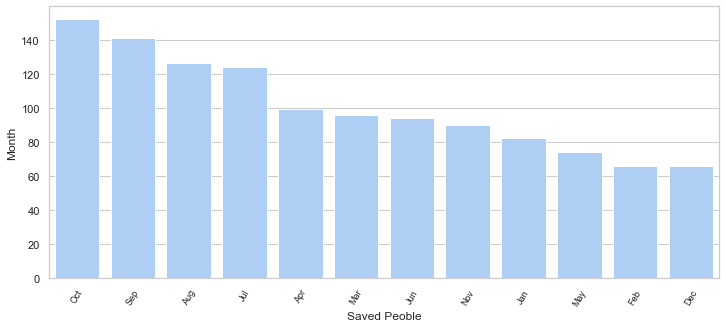

In [350]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(x=activities, y=counts, color='#a2cffe', ax=ax)
ax.set(ylabel="Month", xlabel="Saved Peoble")

ticks = plt.setp(ax.get_xticklabels(), rotation=60, fontsize=9)

In [349]:
import seaborn as sns

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

In [ ]:
#El mes en el que mas gente consigue salvarse de los ataques de tiburon es Octubre.
# esto hay que analizarlo bien ya que no es un relativo
#lo seguro es que en octubre hay mas salvados y en diciembre hay menos ataques
#octubre es el mes del año con mas ataques no mortales a personas que hacer un derporte con tabla. 